In [43]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

import random
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay

In [115]:
mat_df = pd.read_csv("student-mat.csv")
por_df = pd.read_csv("student-por.csv")

# add ID 
mat_df["ID_m"] = list(range(1, len(mat_df) + 1))
por_df["ID_p"] = list(range(1, len(por_df) + 1))

# completely join both dataframes together
outer = mat_df.merge(por_df, how = "outer", on = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"], indicator=True)

# subset to students who only have math grades
math_only_temp = outer[(outer._merge== "left_only")].drop("_merge", axis=1)

# subset to students who only have portugese grades
por_only_temp = outer[(outer._merge == "right_only")].drop("_merge", axis = 1)

both_temp = outer[(outer._merge == "both")].drop("_merge", axis = 1)

random.seed(37)

# assign 0 or 1 to each student
both_temp["rand"] = [int(random.random() >.5) for i in range(0, len(both_temp))]

# if they are assigned 1, collect their math ID
rand_math_ID = list(both_temp[(both_temp["rand"] == 1)]["ID_m"])

# if assigned 0, collect their portugese ID
rand_por_ID = list(both_temp[(both_temp["rand"] == 0)]["ID_p"])

# create a new column to identify subject students grade is for
mat_df["Subject"] = "Math"
por_df["Subject"] = "Portugese"

# get ID's of those only enrolled in math
math_only_ID = list(math_only_temp["ID_m"])
# concat all the ID's of math students
all_math_ID = math_only_ID + rand_math_ID

# get ID's of those only enrolled in portugese
por_only_ID = list(por_only_temp["ID_p"])
# concat all the ID's of the portugese students
all_por_ID = por_only_ID + rand_por_ID

# get the dataframes with all the selected IDs
por_only_df = por_df[por_df["ID_p"].isin(all_por_ID)]
mat_only_df = mat_df[mat_df["ID_m"].isin(all_math_ID)]

complete_df = pd.concat([por_only_df, mat_only_df])

In [116]:
complete_df.reset_index(drop = True, inplace = True)
complete_df = complete_df.sample(frac=1)

In [117]:
complete_df.schoolsup = complete_df.schoolsup.eq('yes').mul(1)
complete_df.famsup = complete_df.famsup.eq('yes').mul(1)
complete_df.nursery = complete_df.nursery.eq('yes').mul(1)
complete_df.higher = complete_df.higher.eq('yes').mul(1)
complete_df.address = complete_df.address.eq('U').mul(1)
complete_df.internet = complete_df.internet.eq('yes').mul(1)

In [5]:
# Support vs. No Support OLS Regression Results
complete_df = complete_df.assign(all_sup = complete_df['schoolsup'] + complete_df['famsup'])
complete_df = complete_df.assign(all_high_ed = complete_df['nursery'] + complete_df['higher'])
complete_df = complete_df.assign(total_alc = complete_df['Dalc'] + complete_df['Walc'])
complete_df['parents_education'] = complete_df['Medu'] + complete_df['Fedu']

In [6]:
rand_index = random.randint(1, 675)
rand_index

217

In [7]:
num_training = 0
num_testing = 0

if(rand_index >= 338):
    num_training = rand_index
    num_testing = 676 - rand_index
    
else:
    num_training = 676 - rand_index
    num_testing = rand_index

print(num_training)
print(num_testing)

459
217


In [8]:
complete_df.iloc[0:num_training]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,G1,G2,G3,ID_p,Subject,ID_m,all_sup,all_high_ed,total_alc,parents_education
545,GP,M,16,1,LE3,T,2,1,at_home,other,...,12,13,14,NaN,Math,152.0,0,2,8,3
163,GP,M,17,0,GT3,T,2,2,other,services,...,9,10,10,298.0,Portugese,NaN,0,0,2,4
635,GP,M,19,1,GT3,T,1,2,other,services,...,13,11,11,NaN,Math,313.0,0,1,4,3
248,GP,M,18,0,GT3,T,2,3,other,services,...,13,14,14,419.0,Portugese,NaN,0,2,9,5
276,MS,M,15,1,LE3,T,3,3,at_home,at_home,...,11,11,11,447.0,Portugese,NaN,1,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,GP,M,19,1,GT3,T,3,3,other,other,...,15,14,13,NaN,Math,305.0,1,2,2,6
354,MS,F,16,0,LE3,T,3,4,at_home,other,...,7,9,8,525.0,Portugese,NaN,1,1,2,7
300,MS,F,15,0,GT3,T,3,3,services,other,...,13,12,12,471.0,Portugese,NaN,1,2,2,6
269,MS,F,15,0,GT3,T,3,3,other,services,...,14,16,16,440.0,Portugese,NaN,0,1,2,6


In [9]:
complete_df.iloc[num_training:676]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,G1,G2,G3,ID_p,Subject,ID_m,all_sup,all_high_ed,total_alc,parents_education
516,GP,M,16,0,GT3,T,4,3,services,other,...,11,15,15,NaN,Math,97.0,2,1,2,7
123,GP,F,17,1,GT3,T,3,2,other,other,...,17,18,17,241.0,Portugese,NaN,0,1,4,5
441,MS,F,17,0,GT3,T,4,4,teacher,services,...,12,12,12,615.0,Portugese,NaN,1,2,3,8
570,GP,F,17,1,LE3,T,2,4,services,services,...,14,15,15,NaN,Math,196.0,0,2,2,6
206,GP,F,17,1,LE3,A,3,3,services,other,...,12,12,13,367.0,Portugese,NaN,2,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,GP,F,19,0,GT3,T,3,2,services,services,...,9,8,10,323.0,Portugese,NaN,2,1,7,5
237,GP,F,21,1,LE3,T,4,4,other,other,...,9,12,12,408.0,Portugese,NaN,0,2,2,8
30,GP,F,16,1,GT3,T,3,1,services,other,...,10,9,10,68.0,Portugese,NaN,2,2,3,4
84,GP,M,18,1,LE3,T,1,1,other,other,...,11,9,0,164.0,Portugese,NaN,0,1,7,2


In [10]:
def pass_or_fail(grades):
    if grades >= 10:
        return 'P'
    else:
        return 'F'

In [19]:
grade_X = complete_df[['parents_education', 'address', 'higher', 'Dalc', 'internet']]
grade_Y = np.array(complete_df['G3'].apply(pass_or_fail))

array(['P', 'P', 'P', 'P', 'P', 'F', 'P', 'P', 'P', 'P', 'P', 'P', 'F',
       'F', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'F', 'P', 'P', 'P', 'P',
       'F', 'P', 'P', 'P', 'P', 'P', 'P', 'F', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'F', 'P', 'P', 'F', 'P', 'P', 'P', 'F', 'P', 'P', 'P', 'P', 'P',
       'P', 'F', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'F', 'P', 'P', 'F', 'F', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'F', 'P', 'P', 'P',
       'P', 'P', 'P', 'P', 'P', 'P', 'P', 'F', 'P', 'P', 'P', 'P', 'F',
       'P', 'F', 'P', 'F', 'P', 'F', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'F', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'F', 'P', 'P',
       'P', 'P', 'P', 'F', 'F', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P',
       'P', 'P', 'F', 'P', 'F', 'P', 'P', 'P', 'P', 'F', 'F', 'P', 'P',
       'F', 'P', 'P', 'P', 'P', 'P', 'P', 'F', 'P', 'F', 'F', 'P

In [12]:
grade_train_X = grade_X[0:num_training]
grade_test_X = grade_X[num_training:676]
grade_train_Y = grade_Y[0:num_training]
grade_test_Y = grade_Y[num_training:676]

In [13]:
def train_SVM(X, y, kernel='linear'):
    clf = SVC(kernel=kernel)
    clf.fit(X, y)
    
    return clf

In [14]:
grade_clf = train_SVM(grade_train_X, grade_train_Y)

In [15]:
grade_predicted_train_Y = grade_clf.predict(grade_train_X)
grade_predicted_test_Y = grade_clf.predict(grade_test_X)

In [16]:
class_report_train = classification_report(grade_train_Y, grade_predicted_train_Y)
print(class_report_train)

              precision    recall  f1-score   support

           F       0.00      0.00      0.00       101
           P       0.78      1.00      0.88       358

    accuracy                           0.78       459
   macro avg       0.39      0.50      0.44       459
weighted avg       0.61      0.78      0.68       459



In [17]:
class_report_test = classification_report(grade_test_Y, grade_predicted_test_Y)
print(class_report_test)

              precision    recall  f1-score   support

           F       0.00      0.00      0.00        58
           P       0.73      1.00      0.85       159

    accuracy                           0.73       217
   macro avg       0.37      0.50      0.42       217
weighted avg       0.54      0.73      0.62       217



In [18]:
conf_mat_train = confusion_matrix(grade_train_Y, grade_predicted_train_Y)
print(conf_mat_train)

[[  0 101]
 [  0 358]]


## Sheily's stuff

In [133]:
complete_df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'ID_p', 'Subject',
       'ID_m'],
      dtype='object')

In [163]:
grade_X = complete_df[['schoolsup', 'famsup', 'nursery', 'Dalc', 'Walc', 'Fedu', 'Medu', 'failures', 'absences', 'freetime']]
grade_Y = np.array(complete_df['G3'].apply(pass_or_fail))

grade_X

,schoolsup,famsup,nursery,Dalc,Walc,Fedu,Medu,failures,absences,freetime
229,0,1,1,1,2,3,2,0,0,3
438,0,1,1,1,4,1,1,3,0,5
124,0,1,0,1,3,3,2,0,0,3
276,0,1,1,1,1,3,3,0,0,3
588,0,0,1,1,2,3,4,0,14,2
...,...,...,...,...,...,...,...,...,...,...
172,0,0,1,1,4,4,4,0,6,2
565,0,1,1,2,3,3,3,0,56,3
26,1,1,0,5,5,1,1,0,0,5
194,0,0,1,1,1,2,3,2,0,5


In [164]:
grade_train_X, grade_test_X, grade_train_Y, grade_test_Y = train_test_split(grade_X, grade_Y, test_size=0.2, random_state=42)


In [181]:
def train_SVM_weights(X, y, kernel='linear', weights = {"F": 3, "P": 1}):
    clf = SVC(kernel=kernel, class_weight = weights)
    clf.fit(X, y)
    
    return clf

In [182]:
grade_clf = train_SVM_weights(grade_train_X, grade_train_Y)

In [183]:
grade_predicted_train_Y = grade_clf.predict(grade_train_X)
grade_predicted_test_Y = grade_clf.predict(grade_test_X)

In [184]:
class_report_train = classification_report(grade_train_Y, grade_predicted_train_Y)
print(class_report_train)

              precision    recall  f1-score   support

           F       0.59      0.49      0.53       134
           P       0.84      0.89      0.86       406

    accuracy                           0.79       540
   macro avg       0.72      0.69      0.70       540
weighted avg       0.78      0.79      0.78       540



In [185]:
conf_mat_train = confusion_matrix(grade_train_Y, grade_predicted_train_Y, normalize="all")
print(conf_mat_train)

[[0.12037037 0.12777778]
 [0.08333333 0.66851852]]


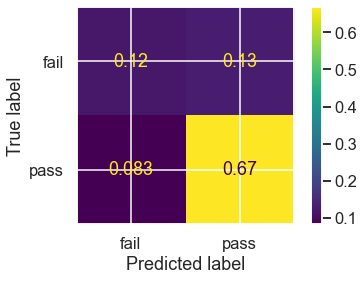

In [186]:
cmd = ConfusionMatrixDisplay(conf_mat_train, display_labels=["fail", "pass"])
cmd.plot()

In [187]:
class_report_test = classification_report(grade_test_Y, grade_predicted_test_Y)
print(class_report_test)

              precision    recall  f1-score   support

           F       0.36      0.36      0.36        25
           P       0.86      0.86      0.86       111

    accuracy                           0.76       136
   macro avg       0.61      0.61      0.61       136
weighted avg       0.76      0.76      0.76       136



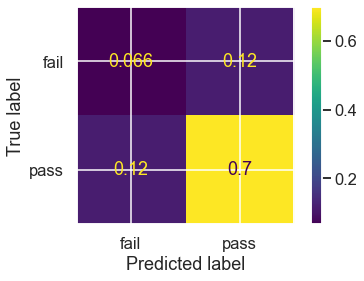

In [188]:
conf_mat_test = confusion_matrix(grade_test_Y, grade_predicted_test_Y, normalize="all")
cmd = ConfusionMatrixDisplay(conf_mat_test, display_labels=["fail", "pass"])
cmd.plot()